In [115]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

## Preparation of Data
In this part, we first read in the data. Then we calculate the means and standard errors.

In [116]:
#Read in data from the csv file
data012_table = np.loadtxt('dataset 012.csv', delimiter=',', skiprows=1)
data012 = {
    "time": data012_table[:,0],            #time
    "force": data012_table[:,1]-0.2,       #force (minus weight of hook)
    "displacement": data012_table[:,2],    #displacement
}
data011_table = np.loadtxt('dataset 011.csv', delimiter=',', skiprows=1)
data011 = {
    "time": data011_table[:,0],            #time
    "force": data011_table[:,1]-0.2,       #force (minus weight of hook)
    "displacement": data011_table[:,2],    #displacement
}
dataset2_table = np.loadtxt('dataset 023.csv', delimiter=',', skiprows=1)
dataset2 = {
    "time": dataset2_table[:,0],  #time
    "acc": dataset2_table[:,2],  #y acc
    "force": dataset2_table[:,4],  #force
}

def get_data_slice(data, start=0, stop=-1, step=None):
    val = {}
    for item in data.keys():
        val[item] = data[item][start:stop:step]
    return val
    

In [117]:
mass_iolab = .204

## Part 01

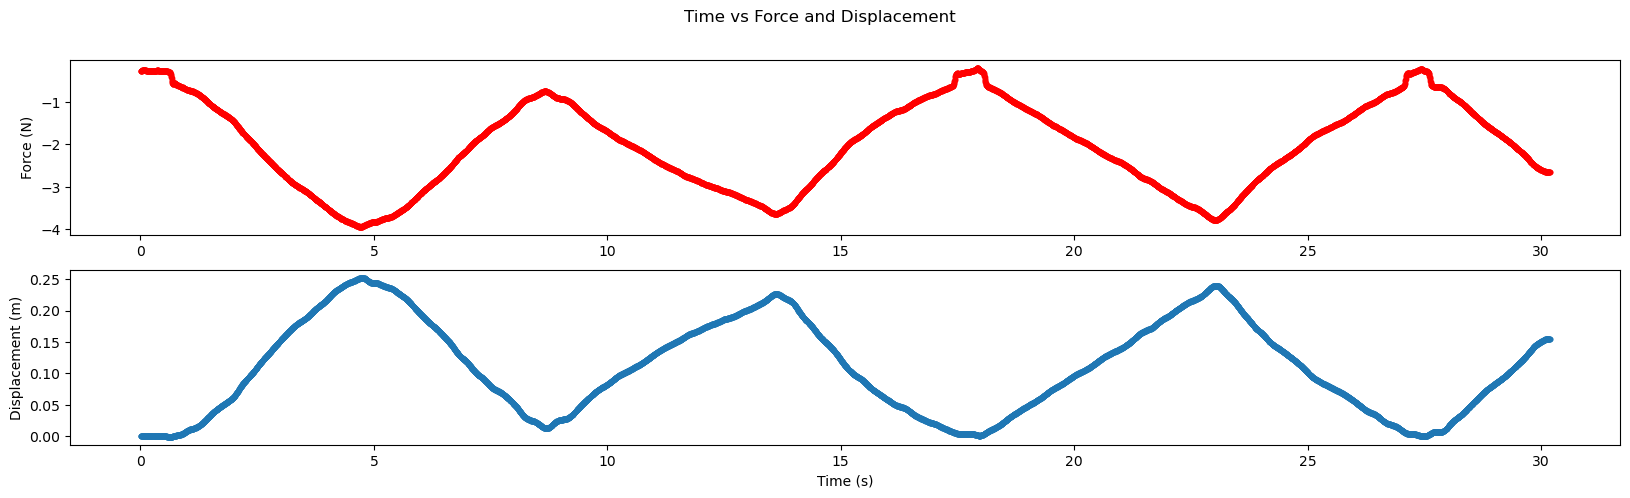

In [118]:
fig1, data01 = plt.subplots(2, figsize=(20,5))
fig1.suptitle("Time vs Force and Displacement")
data01[0].scatter(data012["time"], data012["force"], color="red", s=10)
data01[0].set(ylabel="Force (N)")
data01[1].scatter(data012["time"], data012["displacement"], s=10)
data01[1].set(xlabel="Time (s)", ylabel="Displacement (m)")
plt.show()

### Task: Find Spring Constant

1. select a spring de/extension
2. fit force and distance to find f=-kx
3. find uncertainty a_k
4. compare to accepted value (12 +- 10%)

[Text(0.5, 0, 'Time (s)'), Text(0, 0.5, 'Displacement (m)')]

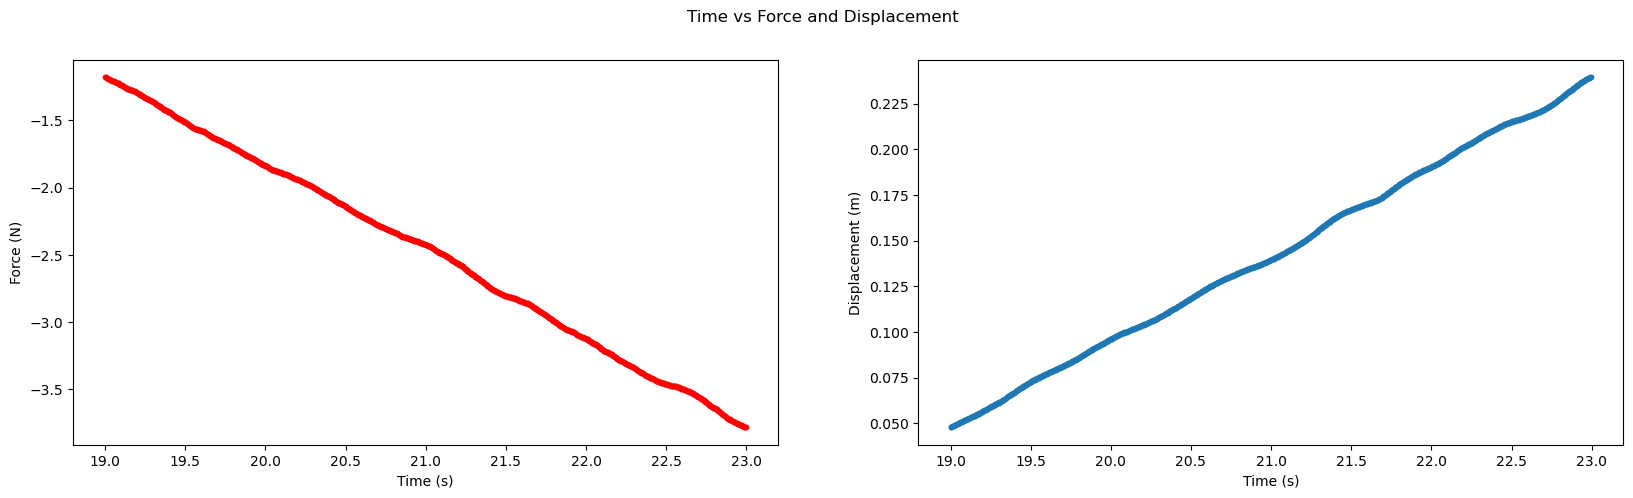

In [119]:
# get the data from 5-8 seconds, which is the first de-extension
extension_begin = list(data012["time"]).index(19)
extension_end = list(data012["time"]).index(23)
slice012 = get_data_slice(data012, extension_begin, extension_end)

#graph it
fig1, slice01 = plt.subplots(1, 2, figsize=(20,5))
fig1.suptitle("Time vs Force and Displacement")
slice01[0].scatter(slice012["time"], slice012["force"], color="red", s=10)
slice01[0].set(xlabel="Time (s)", ylabel="Force (N)")
slice01[1].scatter(slice012["time"], slice012["displacement"], s=10)
slice01[1].set(xlabel="Time (s)", ylabel="Displacement (m)")

In [120]:
calculated_spring_constants = [
    0 - (slice012["force"][i] / slice012["displacement"][i])
    for i in range(extension_end - extension_begin)
]
print(calculated_spring_constants)

[24.65864665003182, 24.582815641366885, 24.50768020287101, 24.443084581325046, 24.407043824177318, 24.371333691925496, 24.345693890024748, 24.328401662813008, 24.25642779549336, 24.185098185067748, 24.114403020381083, 24.05392901234911, 24.01130493396017, 23.95183504970528, 23.910007785676534, 23.84204013090402, 23.784116086970133, 23.77322419156677, 23.767713640820478, 23.751418461506912, 23.73727972135617, 23.7009839581766, 23.686471934288566, 23.635789537487124, 23.60601535897101, 23.576494165685453, 23.547217272261012, 23.53776113510587, 23.52401566774727, 23.475039673424455, 23.437481534817955, 23.384572199434373, 23.347662758511007, 23.2774850088883, 23.192475881003364, 23.113623800342527, 23.031159620223328, 22.976991617258886, 22.951488435270015, 22.907760333601114, 22.85144066731545, 22.807905914967087, 22.815758659719656, 22.814787434433782, 22.790552645826683, 22.74853785530966, 22.694316240437686, 22.644087861564827, 22.6209150391708, 22.59791569869985, 22.575088472139182, 

## Part 02

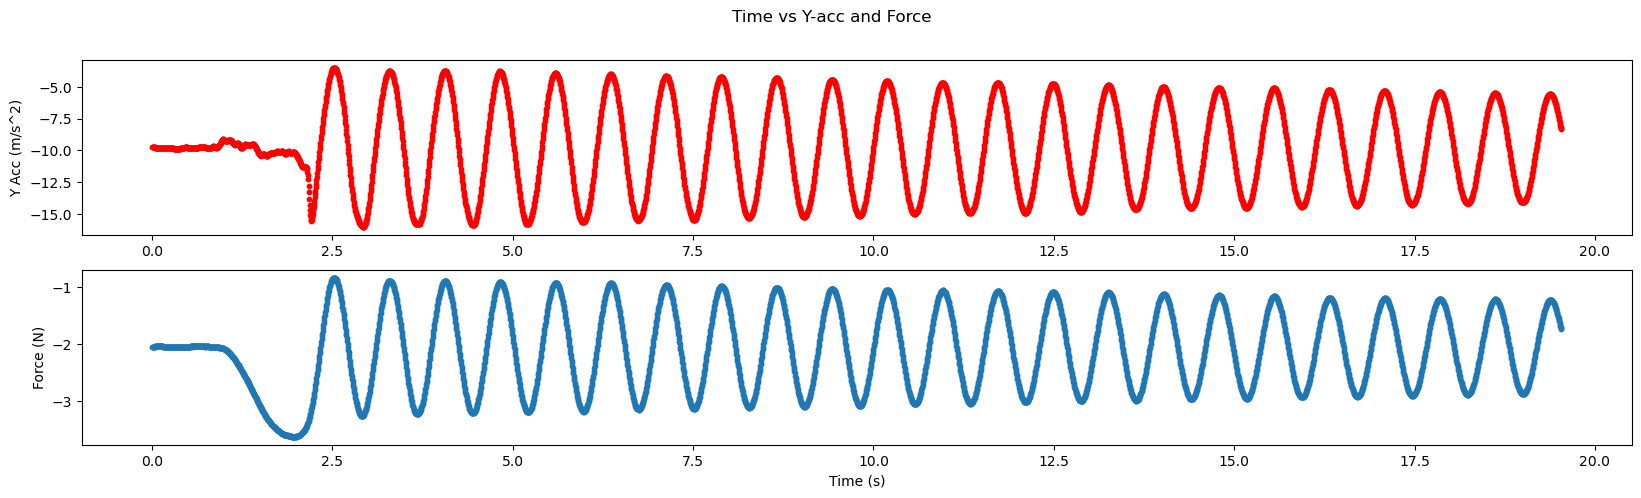

In [121]:
fig2, data2 = plt.subplots(2, figsize=(20,5))
fig2.suptitle("Time vs Y-acc and Force")
data2[0].scatter(dataset2["time"], dataset2["acc"], color="red", s=10)
data2[0].set(ylabel="Y Acc (m/s^2)")
data2[1].scatter(dataset2["time"], dataset2["force"], s=10)
data2[1].set(xlabel="Time (s)", ylabel="Force (N)")
plt.show()

In [122]:
# #IGNORE NOT DOING ANYTHING YET

# #mean
# #axis = 1 meaning we are average each row
# mean = np.mean(time_table, axis=1)
# print('mean :')
# print(mean)

# #standard deviation
# std = np.std(time_table, axis=1, ddof=1)
# print('standard deviation :')
# print(std)

# #standard error
# stderr = std/np.sqrt(7)
# print('standard error')
# print(stderr)

[Text(0.5, 0, 'Time (s)'), Text(0, 0.5, 'Acceleration (m/s^2)')]

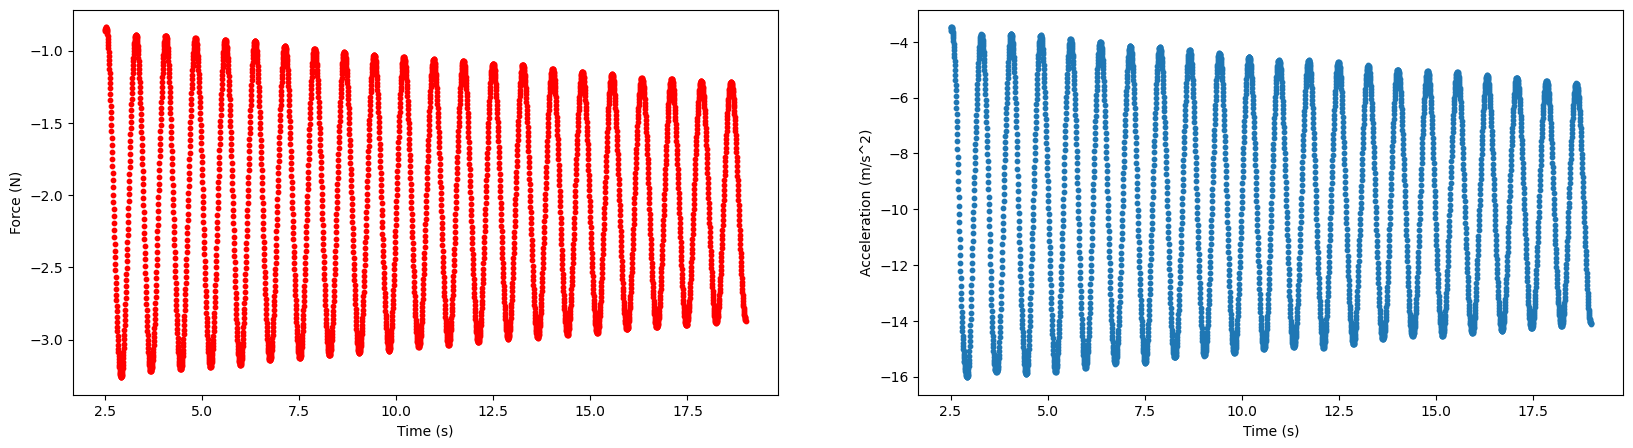

In [123]:
# get the data from 2.5-19 seconds, which is the first de-extension
extension_begin_part_2 = list(dataset2["time"]).index(2.5)
extension_end_part_2 = list(dataset2["time"]).index(19)
slice_part_2 = get_data_slice(dataset2, extension_begin_part_2, extension_end_part_2)

# Load the sliced data
time_slice_part_2 = slice_part_2["time"]
acc_slice_part_2 = slice_part_2["acc"]
force_slice_part_2 = slice_part_2["force"]

#graph it
fig1_part_2, slice_2 = plt.subplots(1, 2, figsize=(20,5))
fig1.suptitle("Time vs Force and Displacement")
slice_2[0].scatter(time_slice_part_2, force_slice_part_2, color="red",s=10)
slice_2[0].set(xlabel="Time (s)", ylabel="Force (N)")
slice_2[1].scatter(time_slice_part_2, acc_slice_part_2, s=10)
slice_2[1].set(xlabel="Time (s)", ylabel="Acceleration (m/s^2)")

#### Part 2 Simple Harmonic Fit

In [124]:
# Define the simple harmonic function
# -A(Wo)^2cos (Wot+ϕ)
def ayharmonict(t, A, Wo, phi):
    return -A * (Wo**2) * np.cos(Wo * t + phi)

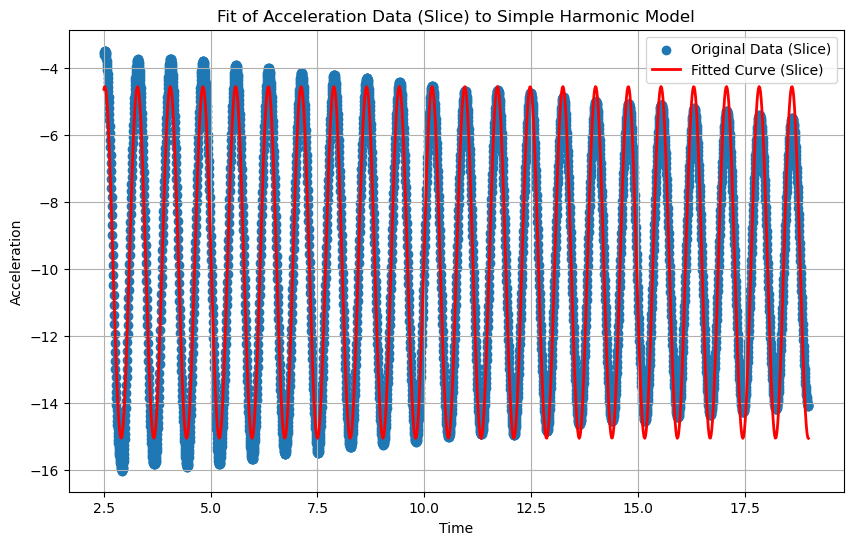

In [164]:
# Inital guesses
guess_A_02_f1 = .1
guess_Wo_02_f1 = 8
guess_phi_02_f1 = 1.5*np.pi

# Fit the sliced data to the model
popt_slice_02_f1, pcov_slice_02_f1 = curve_fit(ayharmonict, time_slice_part_2, acc_slice_part_2, p0=[guess_A_02_f1, guess_Wo_02_f1, guess_phi_02_f1])
A_fit_slice_02_f1, Wo_fit_slice_02_f1, phi_fit_slice_02_f1 = popt_slice_02_f1

# Generate data points for the fitted curve
time_fit_slice_02_f1 = np.linspace(min(time_slice_part_2), max(time_slice_part_2), 1000)
acceleration_fit_slice_02_f1 = ayharmonict(time_fit_slice_02_f1, A_fit_slice_02_f1, Wo_fit_slice_02_f1, phi_fit_slice_02_f1) - 9.8

# Plot the sliced original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(time_slice_part_2, acc_slice_part_2, label='Original Data (Slice)')
plt.plot(time_fit_slice_02_f1, acceleration_fit_slice_02_f1, color='red', label='Fitted Curve (Slice)', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Fit of Acceleration Data (Slice) to Simple Harmonic Model')
plt.legend()
plt.grid(True)
plt.show()

In [165]:
# Derive the spring constant (k = m * (Wo^2))
k_fit_slice_02_f1 = mass_iolab * Wo_fit_slice_02_f1**2

print("Parameters (Slice):")
print("Amplitude (A):", A_fit_slice_02_f1)
print("Angular frequency (Wo):", Wo_fit_slice_02_f1)
print("Phase (phi):", phi_fit_slice_02_f1)
print()
print("Spring constant (k):", k_fit_slice_02_f1)

Parameters (Slice):
Amplitude (A): 0.07809735610177669
Angular frequency (Wo): 8.201878677100286
Phase (phi): 1.3104803430656786

Spring constant (k): 13.723246022109956


#### Part 2 Damped Fit

In [127]:
# Define the damped harmonic function
def aydampedt(t, A, B, W, phi):
    exponent = -B * t
    cos_term = (B**2 - W**2) * np.cos(W * t + phi)
    sin_term = 2 * B * W * np.sin(W * t + phi)
    
    return A * np.exp(exponent) * (cos_term + sin_term)

c:\Users\Arjun\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


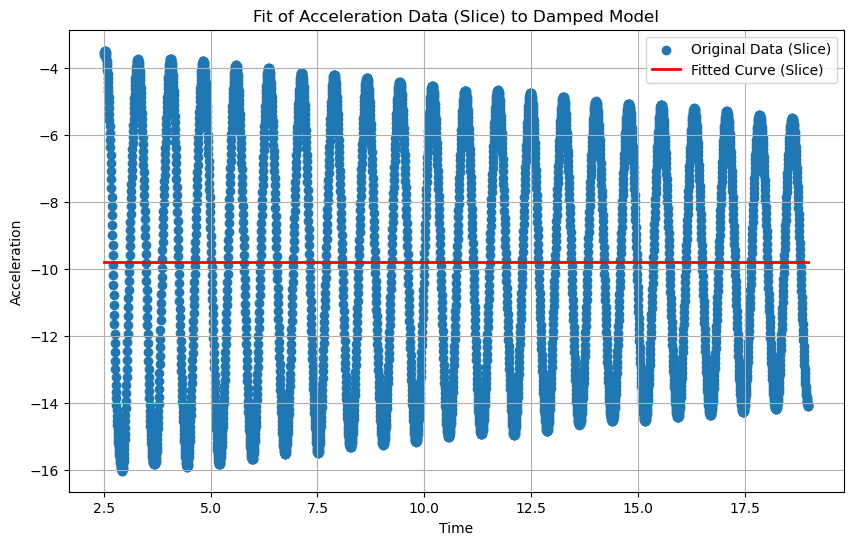

In [166]:
# Initial guesses
guess_A_02_f2 = 1
guess_B_02_f2 = 1
guess_W_02_f2 = 1
guess_phi_02_f2 = np.pi

popt_slice_02_f2, pcov_slice_02_f2 = curve_fit(aydampedt, time_slice_part_2, acc_slice_part_2, maxfev= 10000, p0=[guess_A_02_f2, guess_B_02_f2, guess_W_02_f2, guess_phi_02_f2])
A_fit_02_f2, B_fit_02_f2, W_fit_02_f2, phi_fit_02_f2 = popt_slice_02_f2

# Generate data points for the fitted curve
time_fit_slice_02_f2 = np.linspace(min(time_slice_part_2), max(time_slice_part_2), 1000)
acceleration_fit_slice_02_f2= aydampedt(time_fit_slice_02_f2, A_fit_02_f2, B_fit_02_f2, W_fit_02_f2, phi_fit_02_f2) - 9.8

# Plot the sliced original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(time_slice_part_2, acc_slice_part_2, label='Original Data (Slice)')
plt.plot(time_fit_slice_02_f2, acceleration_fit_slice_02_f2, color='red', label='Fitted Curve (Slice)', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Fit of Acceleration Data (Slice) to Damped Model')
plt.legend()
plt.grid(True)
plt.show()

In [158]:
# Extract the fitted parameters
# W = sqrt(Wo^2 - B^2) --> Wo = W^2 + B^2
# Wo = sqrt(k/m) --> k = m*Wo^2

# Calculate k value
Wo_fit_slice_02_f2 = W_fit_02_f2**2 + B_fit_02_f2**2
k_test = mass_iolab * W_fit_02_f2**2
k_02_f2 = mass_iolab * Wo_fit_slice_02_f2**2

print("Fitted Parameters (Slice):")
print("Amplitude (A):", A_fit_02_f2)
print("Beta (B):", B_fit_02_f2)
print("Original Angular frequency (W):", W_fit_02_f2)
print("Phase (phi):", phi_fit_02_f2)
print()
print("Calculated Values:")
print("Angular frequency (Wo):", Wo_fit_slice_02_f2)
print("K test value (k):", k_test)
print("Spring constant (k):", k_02_f2)

Fitted Parameters (Slice):
Amplitude (A): 24889.09748009697
Beta (B): -0.0028178186804974706
Original Angular frequency (W): 0.01946507624135973
Phase (phi): 6.487900195996388

Calculated Values:
Angular frequency (Wo): 0.0003868292951981075
K test value (k): 7.729339538871719e-05
Spring constant (k): 3.0525928339186775e-08


## Part 03